- competition/dataset : [https://www.kaggle.com/c/spooky-author-identification](https://www.kaggle.com/c/spooky-author-identification)
- date : 2021/03/12
- original : [https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author](https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author)

## Simple Feature Engg Notebook - Spooky Author

**✏ 필사 1회** 

**대회의 목표:**  
테스트 셋의 문장의 작가들을 정확하게 구분하는 것  

**노트북의 목표:**  
작가를 구분하는데 도움을 줄 수 있는 다른 feature를 생성

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words('english'))
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings('ignore')

In [33]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
print('Number of rows in train dataset:', train_df.shape[0])
print('Number of rows in test dataset:', test_df.shape[0])

Number of rows in train dataset: 19579
Number of rows in test dataset: 8392


In [34]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


각 작가들의 발생 횟수를 확인하여 클래스들이 균형을 이루는지 확인할 수 있습니다.

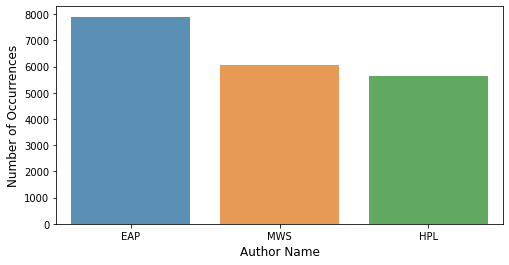

In [35]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

클래스 불균형이 심하지는 않은 것 같습니다. 각 저자들의 텍스트를 몇 줄씩 인쇄하여 가능하다면 작문 스타일을 이해해봅시다.

In [36]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print('Author name:', name)
    cn = 0
    for i, row in group.iterrows():
        print(row['text'])
        cn += 1
        if cn == 5:
            break
    print('\n')

Author name: EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you could 

한 가지 확인할 수 있는 것은 텍스트 데이터에 특수 문자가 많다는 것입니다. 특수 문자들의 수가 좋은 feature가 될 수도 있습니다. 이후에 만들어보겠습니다.  

그것 말고는 단서를 찾기가 어렵습니다.  

**Feature Engineering:**  
이제 약간의 feature engineering을 시도해보겠습니다. 크게 두 가지 파트로 나누어 진행합니다.  

1. Meta Features: 단어 수, 불용어의 수, 특수문자의 수와 같이 텍스트로부터 추출한 feature  
2. Text based features: 단어 빈도수, svd, ward2vec 등과 같이 텍스트를 직접적으로 기반으로 한 feature  

**Meta Features:**  
meta feature를 만들고 이들이 작가를 얼마나 잘 에측하는지 확인해보겠습니다. feature 목록은 다음과 같습니다:  
1. 텍스트 내 단어 수  
2. 텍스트 내 고유한 단어 수  
3. 텍스트 내 글자 수  
4. 불용어 수  
5. 특수문자 수  
6. 대문자 단어 수  
7. 첫 글자가 대문자인 단어 수  
8. 단어의 평균 길이

In [37]:
# 텍스트 내 단어 수
train_df['num_words'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['num_words'] = test_df['text'].apply(lambda x: len(str(x).split()))

# 텍스트 내 고유한 단어 수
train_df['num_unique_words'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['num_unique_words'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# 텍스트 내 글자 수
train_df['num_chars'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['num_chars'] = test_df['text'].apply(lambda x: len(str(x)))

# 텍스트 내 불용어 수
train_df['num_stopwords'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df['num_stopwords'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

# 텍스트 내 특수문자 수
train_df['num_punctuations'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['num_punctuations'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# 텍스트 내 대문자 단어 수
train_df['num_words_upper'] = train_df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df['num_words_upper'] = test_df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# 텍스트 내 첫 글자가 대문자인 단어 수
train_df['num_words_title'] = train_df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df['num_words_title'] = test_df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# 텍스트 내 단어의 평균 길이
train_df['mean_word_len'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_len'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

새로운 변수들을 시각화하여 이들이 예측하는 데 도움을 줄 수 있을지 확인해봅시다.

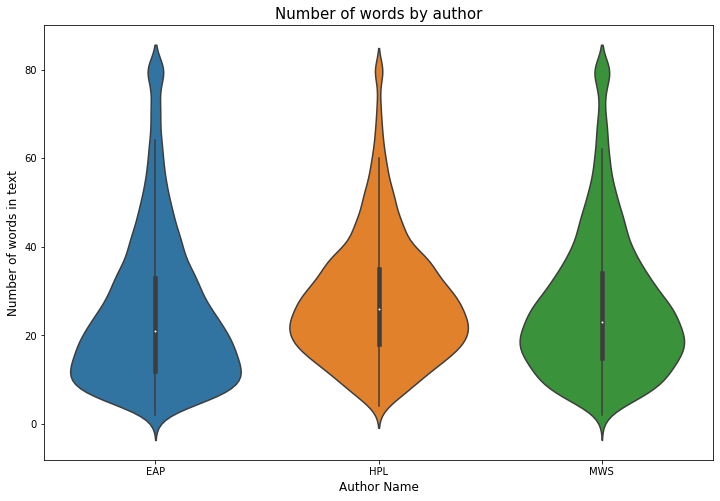

In [38]:
# 더 나은 비주얼을 위해 잘라냄
train_df.loc[train_df['num_words'] > 80, 'num_words'] = 80

plt.figure(figsize=(12, 8))
sns.violinplot('author', 'num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title('Number of words by author', fontsize=15)
plt.show()

단어 수는 EAP가 HPL이나 MWS보다 약간 적은 것 같습니다.

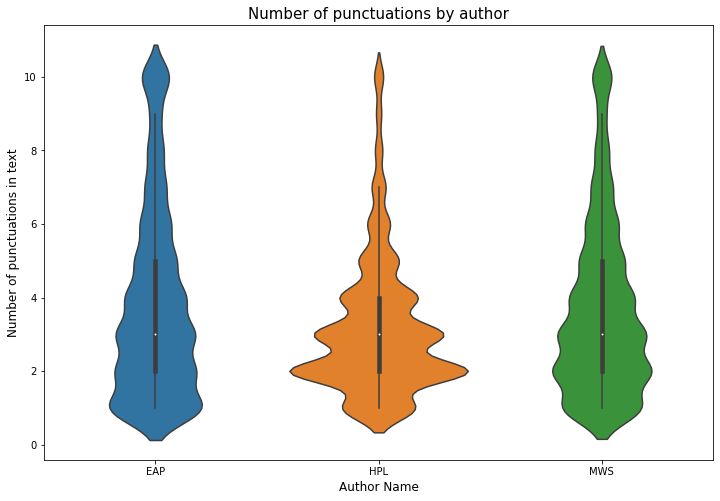

In [39]:
train_df.loc[train_df['num_punctuations'] > 10, 'num_punctuations'] = 10

plt.figure(figsize=(12, 8))
sns.violinplot('author', 'num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of punctuations in text', fontsize=12)
plt.title('Number of punctuations by author', fontsize=15)
plt.show()

이것도 어느정도 유용해 보입니다.  

이번에는 text based feature를 만들어 보겠습니다. 먼저 기본적인 모델을 만들어 meta feature들이 얼마나 도움이 되는지 확인해봅시다.

In [40]:
# 모델링을 위한 데이터 준비
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

# 잘라냈던 변수 다시 계산
train_df['num_words'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['num_words'] = test_df['text'].apply(lambda x: len(str(x).split()))
train_df['num_punctuations'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['num_punctuations'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

cols_to_drop = ['id', 'text']
train_x = train_df.drop(cols_to_drop + ['author'], axis=1)
test_x = test_df.drop(cols_to_drop, axis=1)

이 meta feature들만으로 간단한 XGBoost 모델을 훈련할 수 있습니다.

In [41]:
def runXGB(train_x, train_y, test_x, test_y=None, test_x2=None,
           seed_val=0, child=1, colsample=0.3):
    param = {
        'objective':'multi:softprob',
        'eta':0.1,
        'max_depth':3,
        'silent':1,
        'num_class':3,
        'eval_metric':'mlogloss',
        'min_child_weight':child,
        'subsample':0.8,
        'colsample_bytree':colsample,
        'seed':seed_val
    }
    num_rounds = 2000
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_x, label=train_y)
    
    if test_y is not None:
        xgtest = xgb.DMatrix(test_x, label=test_y)
        watchlist = [(xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist,
                          early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_x)
        model = xgb.train(plst, xgtrain, num_rounds)
    
    pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    if test_x2 is not None:
        xgtest2 = xgb.DMatrix(test_x2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit=model.best_ntree_limit)
    
    return pred_test_y, pred_test_y2, model

커널 실행 시간을 위해 k-fold cross validation의 첫 번째 fold만 확인하겠습니다. 로컬에서 실행할 때는 break를 지워주세요.

In [42]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2021)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])

In [47]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2021)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_x):
    dev_x, val_x = train_x.loc[dev_index], train_x.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_x, dev_y, val_x, val_y, test_x,
                                            seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print('cv scores:', cv_scores)

[12:45:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.09402	test-mlogloss:1.09447
[20]	train-mlogloss:1.04734	test-mlogloss:1.05334
[40]	train-mlogloss:1.02448	test-mlogloss:1.03379
[60]	train-mlogloss:1.01233	test-mlogloss:1.02448
[80]	train-mlogloss:0.99952	test-mlogloss:1.01445
[100]	train-mlogloss:0.99033	test-mlogloss:1.00809
[120]	train-mlogloss:0.98293	test-mlogloss:1.00314
[140]	train-mlogloss:0.97697	test-mlogloss:0.99995
[160]	train-mlogloss:0.97193	test-mlogloss:0.99738
[180]	train-mlogloss:0.96758	test-mlogloss:0.99502
[200]	train-mlogloss:0.96277	test-mlogloss:0.99312
[220]	train-mlogloss:0.95907	test-mlogloss:0.99209
[240]	trai

우리는 meta feature만 사용해서 mlogloss가 0.976인 결과까지 얻었습니다. 나쁘지 않은 점수입니다. 이제, 어떤 변수들이 중요한지 확인해봅시다.

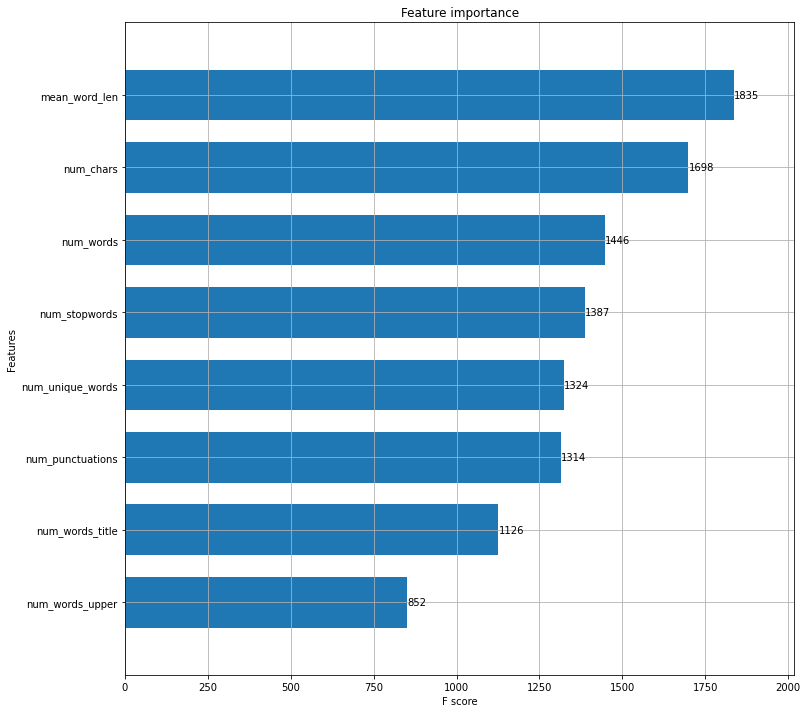

In [49]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=50, height=0.7, ax=ax)
plt.show()

평균 단어 수, 글자 수, 단어 수가 상위 3개의 변수로 확인되었습니다. 이번에는 text based feature을 확인해봅시다.

**Text Based Features:**  
우리가 만들 수 있는 기본적인 feature 중 하나는 텍스트 내 단어의 tf-idf 값입니다.

In [50]:
# tfidf vectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

tfidf vector를 얻었는데, 여기서 조금 까다로운 부분이 있습니다. tfidf 출력은 희소 행렬이므로 다른 dense feature와 함께 사용하려면 몇 가지 선택 사항들이 있습니다:  

1. tfidf vectorizer에서 상위 n개의 feature를 선택하여 dense 포맷으로 바꾼 뒤 다른 feature와 연결할 수 있습니다.   
2. 희소 행렬만을 사용하여 모델을 구축한 뒤 다른 dense feature들과 함께 feature 중 하나로 예측에 사용합니다.  

여기서는 모든 tfidf feature를 사용하여 좋은 성적을 낸 kernel이 있기 때문에 두 번째 방법을 사용할 것입니다.  

또한, Naive Bayes가 이 데이터 셋에서 성능이 좋은 것 같습니다. 따라서 tfidf feature를 사용하여 naive bayes 모델을 구축하겠습니다. ([https://www.kaggle.com/thomasnelson/spooky-simple-naive-bayes-scores-0-399](https://www.kaggle.com/thomasnelson/spooky-simple-naive-bayes-scores-0-399) 참고)

In [51]:
def runMNB(train_x, train_y, test_x, test_y, test_x2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_x, train_y)
    pred_test_y = model.predict_proba(test_x)
    pred_test_y2 = model.predict_proba(test_x2)
    return pred_test_y, pred_test_y2, model

**Naive Bayes on Word Tfidf Vectorizer:**

In [52]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2021)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_x):
    dev_x, val_x = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_x, dev_y, val_x, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print('Mean cv score:', np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score: 0.843252686861949


tfidf vectorizer만을 사용하여 mlogloss가 0.843인 성적을 얻었습니다. meta feature보다 좋은 성적입니다. 혼동 행렬을 살펴봅시다.

In [53]:
# 혼동 행렬 생성 함수
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    혼동 행렬 출력 및 시각화를 위한 함수
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

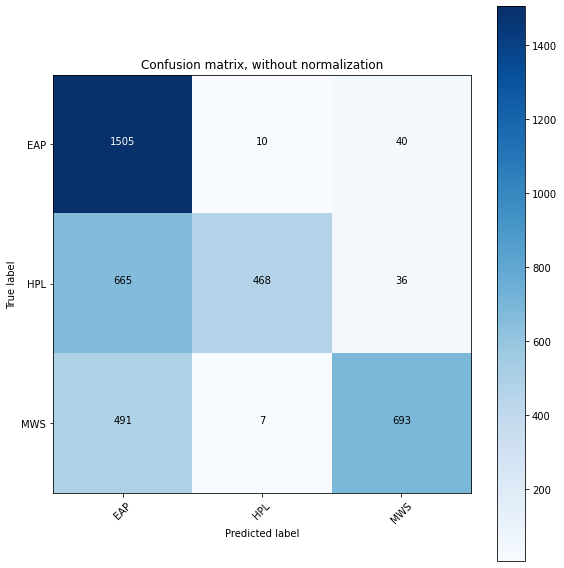

In [54]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
np.set_printoptions(precision=2)

# 정규화되지 않은 혼동행렬 시각화
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

많은 인스턴스들이 EAP로 예측되어 해당 클래스에 매우 편향되어 있습니다.  

**SVD on word TFIDF:**  
tfdif 벡터들은 희소하기 때문에 정보를 압축하여 컴팩트하게 나타내는 또다른 방법은 SDV를 통하는 것입니다. 일반적으로 SVD feature들은 이전 대회들에서도 성능이 괜찮았습니다. 따라서 단어 tfidf에 svd feature를 생성하고 feature 셋에 추가해보겠습니다.

In [55]:
from sklearn.decomposition import TruncatedSVD

n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_' + str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_' + str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

**Naive Bayes on Word Count Vectorizer:**

In [56]:
# count vectorizer
count_vec = CountVectorizer(stop_words='english', ngram_range=(1, 3))
count_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_count = count_vec.transform(train_df['text'].values.tolist())
test_count = count_vec.transform(test_df['text'].values.tolist())

count vectorizer에 기반한 feature을 사용하여 Multinomial NB 모델을 구축해봅시다.

In [57]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2021)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_x):
    dev_x, val_x = train_count[dev_index], train_count[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_x, dev_y, val_x, val_y, test_count)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print('Mean cv score:', np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# 예측값을 새로운 feature로 추가
train_df['nb_cvec_eap'] = pred_train[:, 0]
train_df['nb_cvec_hpl'] = pred_train[:, 1]
train_df['nb_cvec_mws'] = pred_train[:, 2]
test_df['nb_cvec_eap'] = pred_full_test[:, 0]
test_df['nb_cvec_hpl'] = pred_full_test[:, 1]
test_df['nb_cvec_mws'] = pred_full_test[:, 2]

Mean cv score: 0.4518345500791415


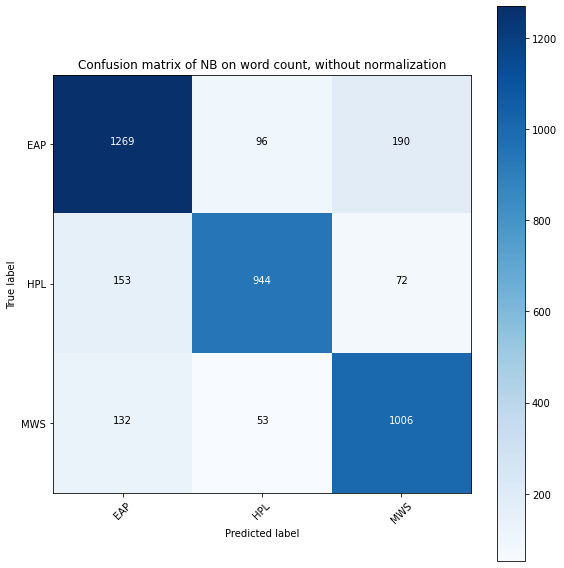

In [58]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
np.set_printoptions(precision=2)

# 정규화되지 않은 혼동행렬 시각화
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

tfidf vectorizer 대신 count vectorizer을 사용하여 mlogloss가 0.452가 나왔습니다. 혼동행렬 또한 이전보다 훨씬 좋아 보입니다.  

**Naive Bayes on Chracter Count Vectorizer:**  
data eyeballing으로부터 얻은 한 가지 아이디어는 특수한 문자를 세는 것이 도움이 될 수 있겠다는 것입니다. 특수한 문자를 그저 세는 대신 문자 수준에 count vectorizer을 사용하여 feature를 얻을 수 있습니다.

In [59]:
# count vectorizer
count_vec = CountVectorizer(ngram_range=(1, 7), analyzer='char')
count_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
full_count = count_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_count = count_vec.transform(train_df['text'].values.tolist())
test_count = count_vec.transform(test_df['text'].values.tolist())

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2021)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_x):
    dev_x, val_x = train_count[dev_index], train_count[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_x, dev_y, val_x, val_y, test_count)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print('Mean cv score:', np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# 예측값을 새로운 feature로 추가
train_df['nb_cvec_char_eap'] = pred_train[:, 0]
train_df['nb_cvec_char_hpl'] = pred_train[:, 1]
train_df['nb_cvec_char_mws'] = pred_train[:, 2]
test_df['nb_cvec_char_eap'] = pred_full_test[:, 0]
test_df['nb_cvec_char_hpl'] = pred_full_test[:, 1]
test_df['nb_cvec_char_mws'] = pred_full_test[:, 2]

Mean cv score: 3.693128964667295


cross val score는 3.69로 매우 높습니다. 그러나 단어 수준에서의 feature와는 다른 정보를 줄 수 있으므로 최종 모델에 사용할 수 있습니다.

**Naive Bayes on Character Tfidf Vectorizer:**  
character tfidf vectorizer에 대한 naive bayes 예측 결과도 확인해보겠습니다.

In [60]:
# tfidf vectorizer
tfidf_vec = TfidfVectorizer(ngram_range=(1, 5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2021)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_x):
    dev_x, val_x = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_x, dev_y, val_x, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print('Mean cv score:', np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# 예측값을 새로운 feature로 추가
train_df['nb_tfidf_char_eap'] = pred_train[:, 0]
train_df['nb_tfidf_char_hpl'] = pred_train[:, 1]
train_df['nb_tfidf_char_mws'] = pred_train[:, 2]
test_df['nb_tfidf_char_eap'] = pred_full_test[:, 0]
test_df['nb_tfidf_char_hpl'] = pred_full_test[:, 1]
test_df['nb_tfidf_char_mws'] = pred_full_test[:, 2]

Mean cv score: 0.7920618182490289


**SVD on Character TFIDF:**  
모델링을 위해 character tfidf feature에 svd feature도 생성할 수 있습니다.

In [61]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_char_' + str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_' + str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

**XGBoost model:**  
이제 이 새로운 변수을 포함하여 다시 xgboost model을 실행하고 결과를 평가해보겠습니다.

In [48]:
dev_index

array([    0,     1,     2, ..., 19576, 19577, 19578])

In [71]:
cols_to_drop = ['id', 'text']
train_x = train_df.drop(cols_to_drop + ['author'], axis=1)
test_x = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2021)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_x):
    dev_x, val_x = train_x.iloc[dev_index], train_x.iloc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_x, dev_y, val_x, val_y, test_x,
                                            seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print('cv scores:', cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv('data/submission_3_sub_fe.csv', index=False)

[12:51:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.00382	test-mlogloss:1.00380
[20]	train-mlogloss:0.41040	test-mlogloss:0.41108
[40]	train-mlogloss:0.33838	test-mlogloss:0.34414
[60]	train-mlogloss:0.31260	test-mlogloss:0.32890
[80]	train-mlogloss:0.29537	test-mlogloss:0.32065
[100]	train-mlogloss:0.28237	test-mlogloss:0.31697
[120]	train-mlogloss:0.27135	test-mlogloss:0.31463
[140]	train-mlogloss:0.26211	test-mlogloss:0.31262
[160]	train-mlogloss:0.25396	test-mlogloss:0.31138
[180]	train-mlogloss:0.24624	test-mlogloss:0.30990
[200]	train-mlogloss:0.23864	test-mlogloss:0.30858
[220]	train-mlogloss:0.23195	test-mlogloss:0.30808
[240]	trai

**이 모델은 val score가 최대 0.307, LB score가 0.32입니다.** 모든 fold를 실행한다면 더 좋은 결과를 얻을 수 있을 것입니다. 이제 중요한 변수들을 다시 한번 확인해보겠습니다.

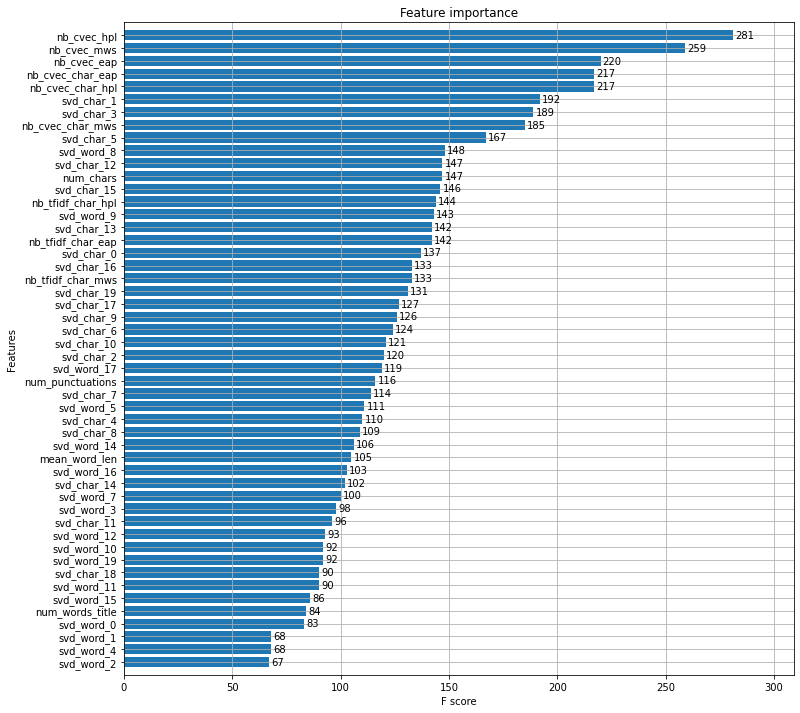

In [72]:
# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

naive bayes feature들이 예상대로 가장 위에 있습니다. 이제 혼동렬을 통해 잘못 분류된 오류들을 확인해보겠습니다.

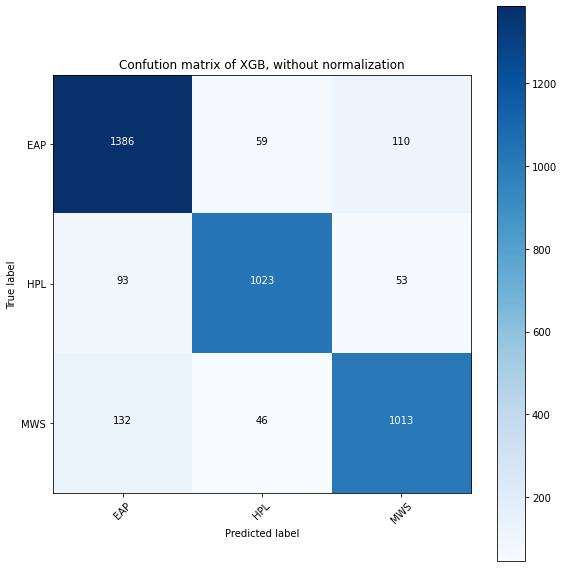

In [73]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
np.set_printoptions(precision=2)

# 정규화하지 않은 혼동행렬 시각화
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confution matrix of XGB, without normalization')
plt.show()

우리는 잠재적으로 이 쌍에 대한 예측을 향상시키는 feature를 만들 수 있습니다.  

**Feature Engineering 이후 단계:**  
* 단어 임베딩 기반 feature 사용  
* 가능하다면 다른 meta feature 확인  
* 문장에 대한 감성 분석  

**성능 향상을 위한 아이디어:**  
* tifdf와 count vectorizer 파라미터 튜닝
* naive bayes와 XGB model 파라미터 튜닝  
* 다른 모델들과 앙상블/스태킹